In [1]:
import numpy as np
import cv2
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimage
import pickle

from ipywidgets import interact, interactive, fixed

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from mpl_toolkits.mplot3d import Axes3D
from functools import partial

from scipy.ndimage.measurements import label

import asyncio

from moviepy.editor import ImageSequenceClip, VideoFileClip
from IPython.display import HTML

from utils import *
from nms import *
%matplotlib inline


# Load Data

In [21]:
cars = []
notcars = []

cars_images = glob.glob('vehicles/*')
for folder in cars_images:
    cars += (glob.glob('{}/*.png'.format(folder)))

notcars_images = glob.glob('non-vehicles/*')
for folder in notcars_images:
    notcars += (glob.glob('{}/*.png'.format(folder)))

# Augment data from Autti

In [11]:
# extracting additional samples from autti dataset
import csv
import random as rand

autti_samples_cars_count = 10000
autti_samples_notcars_count = 40000
autti_images_data = {}
cars_count = 0

# get autti dataset from https://github.com/udacity/self-driving-car/tree/master/annotations
# and extract into dataset/autti-object-dataset/ folder
# reading car boxes data from csv file (lines which contains "car" in 6th row)
# as a result we will have following structute
# autti_images_data = {
#    'image_filename' : {
#        'impath' : 'path/to/image',
#        'car_boxes' : [
#                {
#                    'x1' : int, # top left coords
#                    'y1' : int,
#                    'x2' : int, # bottom right coords
#                    'y2' : int
#                },
#                ...
#                all car boxes
#            ]
#    }
#    ...
#    all files
# }

with open('autti-object-dataset/labels.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in reader:
        fname = row [0]
        if fname not in autti_images_data:
            image_data = {
                'impath' : 'autti-object-dataset/' + fname,
                'car_boxes' : []
            }
            autti_images_data [fname] = image_data
        else:
            image_data = autti_images_data [fname]
            
        if (row[6] == '"car"'):
            car_data = {
                'x1' : int(row [1]),
                'y1' : int(row [2]),
                'x2' : int(row [3]),
                'y2' : int(row [4])
            }
            image_data ['car_boxes'].append (car_data)
            cars_count += 1

print ('autti images:', len (autti_images_data))
print ('  cars:', cars_count)

autti images: 13063
  cars: 60788


In [13]:
def is_intersect (box, boxes):
    """Check if box have intersection with other boxes
    Args:
        box (dict): box coords as
            {
                'x1' : int, # top left coords
                'y1' : int,
                'x2' : int, # bottom right coords
                'y2' : int
            }
        boxes (list): list of other boxes
    Returns:
        boolean: True if box has intersection with boxes, False otherwise
    """
    x1, x2, y1, y2 = box ['x1'], box ['x2'], box ['y1'], box ['y2']
    for b in boxes:
        bx1, bx2, by1, by2 = b ['x1'], b ['x2'], b ['y1'], b ['y2']
        if (
            (
                (
                    (x1 >= bx1 and x1 <= bx2) or 
                    (x2 >= bx1 and x2 <= bx2)
                ) and
                (
                    (y1 >= by1 and y1 <= by2) or 
                    (y2 >= by1 and y2 <= by2)
                )
            ) or
            (
                (
                    (bx1 >= x1 and bx1 <= x2) or 
                    (bx2 >= x1 and bx2 <= x2)
                ) and
                (
                    (by1 >= y1 and by1 <= y2) or 
                    (by2 >= y1 and by2 <= y2)
                )
            )
        ):
            return True
        
    return False

# also not car images will be extracted from autti dataset
# not car images will be square crops with following side size
not_car_box_size = [128, 64, 48]

def gen_not_car_box (size, car_boxes):
    """Randomly generate box inside of specified boundaries
    which have no intersections with specified boxes
    Args:
        size (list or tuple): size of area to generate box within
        car_boxes (list): boxes in the area which cannot be intersected
    Return:
        box(dict): resulting box in form of {'x1' : int, 'y1' : int, 'x2' : int, 'y2' : int}
    """
    while True:
        box_size = not_car_box_size [rand.randint (0, len (not_car_box_size)-1)]
        box_size = [box_size, box_size]
        available_poss = [
            size[0] - box_size[0],
            size[1] - box_size[1],
            ]
        pos = [
            rand.randint (0, available_poss[0] - 1),
            rand.randint (0, available_poss[1] - 1)
            ]
        box = {
            'x1': pos [0],
            'y1': pos [1],
            'x2': pos [0] + box_size [0],
            'y2': pos [1] + box_size [1]
        }
        if not is_intersect (box, car_boxes):
            return box
    

def augment_from_autti_dataset (cars_count, notcars_count):
    """Randomly pick images from autti dataset, crops car and not car images.
    resulting images will be resized to (64, 64)
    Args:
        cars_count (int): number of needed car images
        notcars_count (int): number of needed not car images
    Returns:
        cars (list), notcars(list) images which were cropped from autti dataset
        lists may hold slighly less number of images since
        cars_count and notcars_count specifies number of tries to crop.
        In some rare situations we have no images to crop
    """
    images_last_index = len (autti_images_data) - 1
    augmented_cars = []
    augmented_notcars = []
    keys = list(autti_images_data.keys ())
    for i in range (max (cars_count, notcars_count)):
        if i % 200 == 0:
            print ('augmented:', i)
        
        image_data = autti_images_data [keys[rand.randint (0, images_last_index)]]
        # if there is no car we will skip this image
        if len(image_data ['car_boxes']) == 0:
            continue
        
        carbox = image_data['car_boxes'][rand.randint(0, len(image_data ['car_boxes'])-1)]

        im = mpimg.imread(image_data ['impath'])
        im = im.astype(np.float32)/255

        #get car from image
        if i < cars_count:
            car_im = im[carbox['y1']:carbox['y2'], carbox['x1']:carbox['x2']]
            car_im = cv2.resize(car_im, (64, 64), interpolation=cv2.INTER_AREA)
            augmented_cars.append (car_im)
        
        #get not car from image
        if i < notcars_count:
            notcarbox = gen_not_car_box ([im.shape[1], im.shape[0]], image_data['car_boxes'])
            notcar_im = im[notcarbox['y1']:notcarbox['y2'], notcarbox['x1']:notcarbox['x2']]
            notcar_im = cv2.resize(notcar_im, (64, 64), interpolation=cv2.INTER_AREA)
            augmented_notcars.append (notcar_im)
        
    
    return augmented_cars, augmented_notcars

In [14]:
autti_samples_cars_count = 4000
autti_samples_notcars_count = 6000
augmented_cars, augmented_notcars = augment_from_autti_dataset (autti_samples_cars_count, autti_samples_notcars_count)
print ('augmented cars:', len (augmented_cars))
print ('augmented not cars:', len (augmented_notcars))

augmented: 0
augmented: 200
augmented: 400
augmented: 600
augmented: 800
augmented: 1000
augmented: 1200
augmented: 1400
augmented: 1600
augmented: 1800
augmented: 2000
augmented: 2200
augmented: 2400
augmented: 2600
augmented: 2800
augmented: 3000
augmented: 3200
augmented: 3400
augmented: 3600
augmented: 3800
augmented: 4000
augmented: 4200
augmented: 4400
augmented: 4600
augmented: 4800
augmented: 5000
augmented: 5200
augmented: 5400
augmented: 5600
augmented: 5800
augmented cars: 3910
augmented not cars: 5854


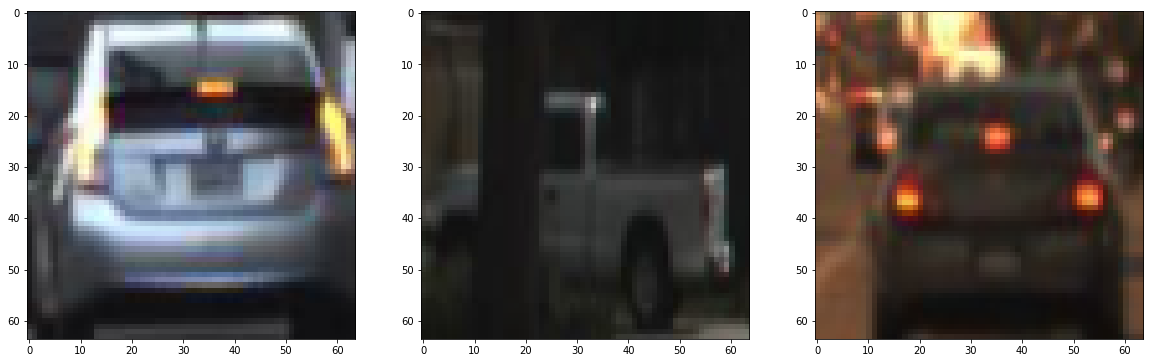

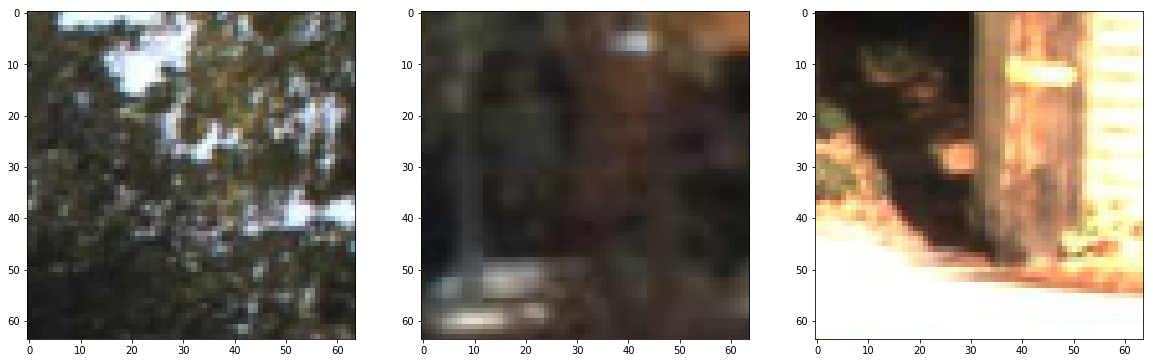

In [15]:
car1 = augmented_cars[random.randint (0, len (augmented_cars)-1)]
car2 = augmented_cars [random.randint (0, len (augmented_cars)-1)]
car3 = augmented_cars [random.randint (0, len (augmented_cars)-1)]

notcar1 = augmented_notcars[random.randint (0, len (augmented_cars)-1)]
notcar2 = augmented_notcars [random.randint (0, len (augmented_cars)-1)]
notcar3 = augmented_notcars [random.randint (0, len (augmented_cars)-1)]

f , (ax1, ax2,ax3) = plt.subplots(1,3,figsize= (20,10))
ax1.imshow(car1)
ax2.imshow(car2)
ax3.imshow(car3)

f , (ax1, ax2,ax3) = plt.subplots(1,3,figsize= (20,10))
ax1.imshow(notcar1)
ax2.imshow(notcar2)
ax3.imshow(notcar3)

# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [2]:
color_space = "YCrCb" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True# Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [18]:
augmented_car_features = extract_features_imgInMemory(augmented_cars, spatial_size=spatial_size,
                        hist_bins= hist_bins, orient= orient, 
                        pix_per_cell=  pix_per_cell, cell_per_block= cell_per_block, hog_channel= hog_channel,
                        spatial_feat=spatial_feat, hist_feat= hist_feat, hog_feat= hog_feat)

In [19]:
augmented_notcar_features = extract_features_imgInMemory(augmented_notcars, spatial_size=spatial_size,
                        hist_bins= hist_bins, orient= orient, 
                        pix_per_cell=  pix_per_cell, cell_per_block= cell_per_block, hog_channel= hog_channel,
                        spatial_feat=spatial_feat, hist_feat= hist_feat, hog_feat= hog_feat)

In [52]:
len(augmented_notcar_features)

1972

In [22]:
#os.chdir('CarND-Vehicle-Detection')
car_features = extract_features(cars, spatial_size=spatial_size,
                        hist_bins= hist_bins, orient= orient, 
                        pix_per_cell=  pix_per_cell, cell_per_block= cell_per_block, hog_channel= hog_channel,
                        spatial_feat=spatial_feat, hist_feat= hist_feat, hog_feat= hog_feat)


notcar_features = extract_features(notcars, spatial_size=spatial_size,
                        hist_bins= hist_bins, orient= orient, 
                        pix_per_cell=  pix_per_cell, cell_per_block= cell_per_block, hog_channel= hog_channel,
                        spatial_feat=spatial_feat, hist_feat= hist_feat, hog_feat= hog_feat)

In [50]:
len(car_features)

8792

In [23]:
car_features = sum([car_features, augmented_car_features],[])
notcar_features = sum([notcar_features, augmented_notcar_features],[])

In [24]:
len(car_features)

12702

In [25]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)      
print("Car samples: %d" % (len(car_features)))
print("NonCar samples: %d" % (len(notcar_features)))

Car samples: 12702
NonCar samples: 14822


In [26]:
from sklearn.utils import shuffle
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Label vectors
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#X_shuffle, y_shuffle = shuffle(scaled_X, y)
# Split up data to training and test set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state= rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [ ]:
# Save data to pickle to access late
import pickle
parameters = {'color_space': color_space,
                  'orient': orient,
                  'pix_per_cell': pix_per_cell,
                  'cell_per_block': cell_per_block,
                  'hog_channel': hog_channel,
                  'spatial_size': spatial_size,
                  'hist_bins': hist_bins,
                  'spatial_feat': spatial_feat,
                  'hist_feat': hist_feat,
                  'hog_feat': hog_feat}

pickle_file = 'feature.p'
with open (pickle_file,'wb') as openfile:
    pickle.dump({
        'train_data': X_train,
        'train_labels': y_train,
        'test_data': X_test,
        'test_labels': y_test,
        'X_scaler': X_scaler,
        'parameters': parameters}, openfile)


In [ ]:
# Reload parameters from pickle files
import pickle
pickle_file = 'feature.p'
with open(pickle_file, 'rb') as openfile:
    data = pickle.load(openfile)

X_train = data['train_data']
y_train = data['train_labels']
X_test = data['test_data']
y_test = data['test_labels']
X_scaler = X_scaler
parameters = data['parameters']
cell_per_block  = parameters['cell_per_block']
color_space = parameters['color_space']
hist_bins = parameters['hist_bins']
hog_channel = parameters['hog_channel']
hog_feat = parameters['hog_feat']
orient = parameters['orient']
pix_per_cell = parameters['pix_per_cell']
spatial_feat = parameters['spatial_feat']
spatial_size = parameters['spatial_size']
hist_feat = parameters['hist_feat']

In [29]:
# Use a SVC 
svc = SVC(kernel= 'rbf')
# Check the training time for the SVC
start_t=time.time()
svc.fit(X_train, y_train)
end_t = time.time()
print(round(end_t - start_t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
#print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

1540.59 Seconds to train SVC...
Test Accuracy of SVC =  0.9826


In [28]:
# Use a linear SVC
linear_svc = LinearSVC()
start_t=time.time()
linear_svc.fit(X_train, y_train)
end_t = time.time()
print(round(end_t - start_t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
#print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(linear_svc.score(X_test, y_test), 4))

43.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9457


## Try ensemble tree classifier
Given SVC only achive 98.11% test accuracy, I wanted to try anotehr classification method. However the below methid run really slow and took much longer time to predict. Hence this is not suitable to run in the pipeline for video

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1,max_depth=None, min_samples_split=10, random_state=0)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train ExtraTrees...')
# Check the score of the RandomForest
print('Train Accuracy of  ExtraTrees = ', round(clf.score(X_train, y_train), 4))
print('Test Accuracy of ExtraTrees = ', round(clf.score(X_test, y_test), 4))

In [ ]:
t1 = time.time()
prediction = svc.predict(X_test[0])
t2 = time.time()
print (round(t2-t1,2))

In [54]:
import pickle
parameters = {'color_space': color_space,
                  'orient': orient,
                  'pix_per_cell': pix_per_cell,
                  'cell_per_block': cell_per_block,
                  'hog_channel': hog_channel,
                  'spatial_size': spatial_size,
                  'hist_bins': hist_bins,
                  'spatial_feat': spatial_feat,
                  'hist_feat': hist_feat,
                  'hog_feat': hog_feat}
pickle_file = 'linearsvc.p'

with open(pickle_file,'wb') as openfile:
    pickle.dump(
    {
        'svc': linear_svc,
        'X_scaler': X_scaler,
        'parameters': parameters
        
    }, openfile, pickle.HIGHEST_PROTOCOL)

# Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [2]:
# Reload parameters from pickle files
pickle_file = 'svc.p'
with open(pickle_file, 'rb') as openfile:
    data = pickle.load(openfile)

In [3]:
X_scaler = data['X_scaler']
parameters = data['parameters']
cell_per_block  = parameters['cell_per_block']
color_space = parameters['color_space']
hist_bins = parameters['hist_bins']
hog_channel = parameters['hog_channel']
hog_feat = parameters['hog_feat']
orient = parameters['orient']
pix_per_cell = parameters['pix_per_cell']
spatial_feat = parameters['spatial_feat']
spatial_size = parameters['spatial_size']
hist_feat = parameters['hist_feat']
svc = data['svc']

6.25


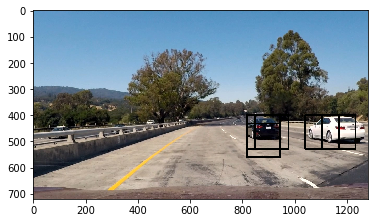

In [4]:
t1 = time.time()
# scale because svc trined on png but test img is jpg
image = mpimage.imread('test_images/test1.jpg').astype(np.float32)/255 
draw_image = np.copy(image)
windows = slide_window(image, x_start_stop=[400, None], y_start_stop=[400, 640], 
                xy_window=(128, 128), xy_overlap=(0.75, 0.75))
hot_windows = []
hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat))                       
window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                    
plt.figure()
plt.imshow(window_img)
plt.savefig('output_images/test_1_augment.png' )
t2 = time.time()
print(round(t2-t1, 2))

# Improve Sliding Window method
To improve speed when we process the whole video clip with multiple image, instead of scan the whole bottom half of the image, we will scan only where a new car can appear and where a car was previously detected (track car)
The strategy is in every frame we look for car nearer to us (i.e. higher y) , and new further car (lower y)

We use multiple scaled box to search for cars in image. The far will have smaller box; the nearer to the picture will have bigger box. We then randomly generate  a number of box. The nearer has less boxes, the further has more boxes 

In [76]:
def multi_scaled_boxes_2(image):
    hot_windows = []
    all_windows = []

    X_start_stop =[[700,1280], [700,1300]]
    w_mid,w_far = 120,100
    o_mid,o_far = 0.75,0.75
    XY_window = [(w_mid,w_mid),(w_far,w_far)]
    XY_overlap = [(o_mid,o_mid),(o_far,o_far)]
    y_mid,y_far= 440,400                
    Y_start_stop =[[y_mid,y_mid+w_mid/2],[y_far,y_far+w_far/2]]      
    
    for i in range(len(Y_start_stop)):
        windows = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])
        
        all_windows += windows
    return all_windows

To demonstrate how the multi scaled box work, below is an example of how near, mid and far boxes are created

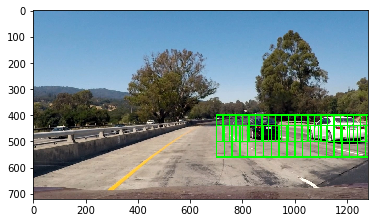

In [77]:
img = mpimage.imread('test_images/test1.jpg')
boxes = multi_scaled_boxes_2(img)
window_img = draw_boxes(img, boxes, color= (0,255,0), thick = 4)
plt.imshow(window_img)
plt.savefig('output_images/slide_multiscaled_window.png')
plt.show()

In [68]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

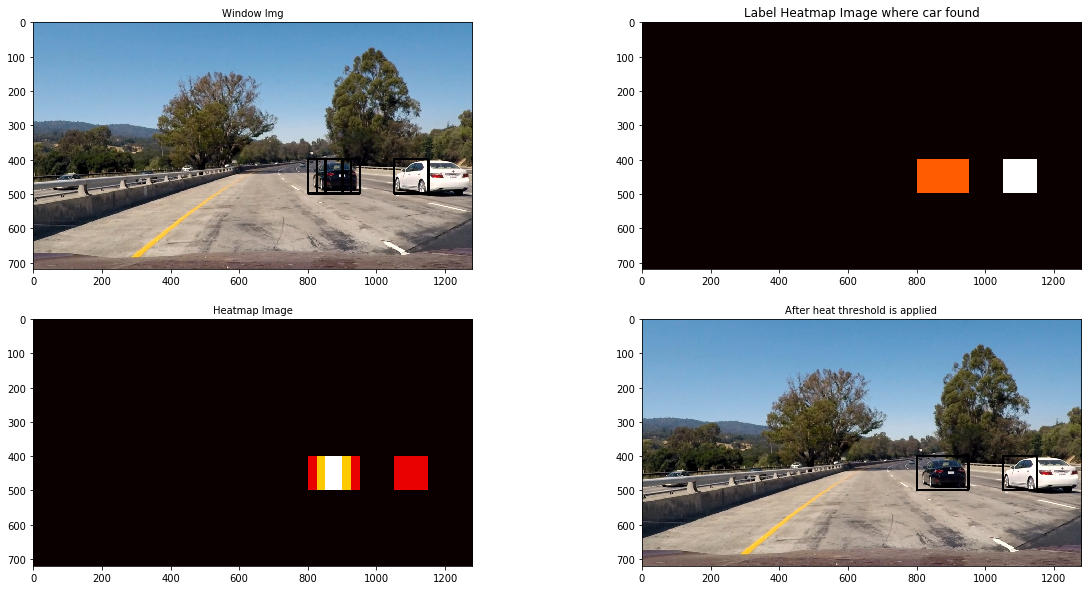

In [78]:
img = mpimage.imread('test_images/test1.jpg')
img = img.astype(np.float32)/255
draw_img = np.copy(img)
windows = multi_scaled_boxes_2(img)
hot_windows = search_windows(img, windows, svc, X_scaler, color_space = color_space,\
                            spatial_size = spatial_size,  hist_bins = hist_bins, orient = orient,
                            pix_per_cell = pix_per_cell,cell_per_block = cell_per_block, hog_channel = hog_channel,\
                            spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
window_img = draw_boxes(draw_img, hot_windows, color = (0,255,0), thick = 6)
heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
heat_threshold = 0.1
heatmap = add_heat(heat, hot_windows)
heatmap = apply_threshold(heatmap, heat_threshold)

labels = label(heatmap)
applied_img = draw_labeled_bboxes(draw_img, labels)

f , ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize= (20,10))
ax1.imshow(window_img)
ax1.set_title('Window Img', fontsize = 10)

ax2.imshow(labels[0], cmap = 'hot')
ax2.set_title('Label Heatmap Image where car found')

ax3.imshow(heatmap, cmap ='hot')
ax3.set_title('Heatmap Image', fontsize = 10)

ax4.imshow(applied_img)
ax4.set_title('After heat threshold is applied', fontsize= 10)

plt.savefig('output_images/classify_heatmap_augment.png')

# Pipeline and Video Implementation

In [73]:
from collections import deque
class BBoxesQ:
    def __init__(self,n= 10):
        # n: length of queue
        self.n = n
        # hot windows of the last n frames
        self.recent_boxes = deque([],maxlen=n)
        # current boxes
        self.current_boxes = None
        self.allboxes = []

    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_boxes.pop()            
    def set_current_boxes(self,boxes):
        self.current_boxes = boxes
        
    def get_all_boxes(self):        
        allboxes = []
        for boxes in self.recent_boxes:
            allboxes += boxes
        if len(allboxes)==0:
            self.allboxes = None
        else:
            self.allboxes = allboxes
            
    def update(self,boxes):
        self.set_current_boxes(boxes)
        self.add_boxes()
        self.get_all_boxes()

In [74]:
bboxesQ = BBoxesQ(n = 10)
def pipeline(img):
    global n_count, hot_windows_even_frame
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    if (n_count % 2 == 0):
        windows = multi_scaled_boxes_2(img)
        hot_windows = search_windows(img, windows, svc, X_scaler, color_space = color_space,\
                                spatial_size = spatial_size,  hist_bins = hist_bins, orient = orient,
                                pix_per_cell = pix_per_cell,cell_per_block = cell_per_block, hog_channel = hog_channel,\
                                spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        hot_windows_even_frame = hot_windows
    else:
        hot_windows = hot_windows_even_frame
        
    bboxesQ.update(hot_windows)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    n_count += 1
    try:
        heatmap = add_heat(heatmap, bboxesQ.allboxes)
        heatmap = apply_threshold(heatmap,7)
        labels = label(heatmap)
        window_img = draw_labeled_bboxes(draw_img, labels)
        return window_img
    except Exception:
        pass
        return draw_img
   

In [75]:
n_count = 0
write_output = 'output_video/test_video_output_svc_10_7_skipframe_scale2.mp4'
clip1 = VideoFileClip('./test_video.mp4')
write_clip = clip1.fl_image(pipeline)    #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video output_video/test_video_output_svc_10_7_skipframe_scale2.mp4
[MoviePy] Writing video output_video/test_video_output_svc_10_7_skipframe_scale2.mp4


 97%|█████████▋| 38/39 [00:29<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/test_video_output_svc_10_7_skipframe_scale2.mp4 

CPU times: user 28.3 s, sys: 575 ms, total: 28.9 s
Wall time: 30.7 s


In [79]:
n_count = 0
write_output = 'output_video/project_videp_processed_augment_skipframe_scale2.mp4'
clip1 = VideoFileClip('./project_video.mp4')
write_clip = clip1.fl_image(pipeline)    #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video output_video/project_videp_processed_augment_skipframe_scale2.mp4
[MoviePy] Writing video output_video/project_videp_processed_augment_skipframe_scale2.mp4


100%|█████████▉| 1260/1261 [19:35<00:01,  1.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_videp_processed_augment_skipframe_scale2.mp4 

CPU times: user 17min 34s, sys: 37.6 s, total: 18min 11s
Wall time: 19min 36s
